In [1]:
import sys
import rosbag
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [2]:
def getData(file,start_time,end_time,transition_stuff=[False,0,0,0]): #transition_stuff = [bool,int motor, float trigger_level, bool rising_edge]
	pos = []
	force = []
	time = []
	bag = rosbag.Bag(file)
	for topic, msg, t in bag.read_messages(topics=["/roboy/middleware/MotorStatus"]):
		pos.append(msg.position)
		force.append(msg.displacement)
		time.append(t.to_sec())
	bag.close()
	time = np.array(time)
	start_time -= time[0]
	end_time -= time[0]
	time -= time[0]
	#print start_time,end_time
	pos = np.array(pos)*position_to_rads
	force = np.array(force)*displacement_to_N
	result = []
	start_time = int(start_time/0.02)+1
	end_time = int(end_time/0.02)+1
	if transition_stuff[0]:
		transition_stuff[2] *= position_to_rads
		done = False
		prev = 0
		curr = 0
		while(not done):
			prev = pos[start_time-3:start_time,transition_stuff[1]].mean()
			curr = pos[start_time:start_time+3,transition_stuff[1]].mean()
			if transition_stuff[3]:
				if curr > transition_stuff[2] and prev < transition_stuff[2]:
					done = True
					break
			else:
				if curr < transition_stuff[2] and prev > transition_stuff[2]:
					done = True
					break
			start_time += 1
			end_time += 1
	result.append(pos[start_time:end_time])
	result.append(force[start_time:end_time])
	result.append(time[start_time:end_time])
	return result

In [3]:
def RMS(base, data):
	return np.sqrt(((base-data)**2).mean())

In [5]:
# some constants
global position_to_rads
global displacement_to_N
global base_files
global base_times
global matrix_filename_to_base_index

# obtain baseline
global fb_base
global fs_base
global sd_base
global baseline

In [9]:
path = '/media/markus/OS/Users/Sefi/Dropbox/data/'
position_to_rads = 2.0*3.14159/(2000.0*53.0);
displacement_to_N = 0.237536
base_files = [path+"steps_fb_fs/0_rising/0_rising_2017-09-14-20-22-54.bag",path+"steps_fb_fs/0_rising/0_rising_2017-09-14-20-22-54.bag", path+"steps_fb_sd/0_rising/steps_fb_sd_0_rising_2017-09-14-23-37-30.bag"]
base_times = [(16.828+1505413374.96, 19.395+1505413374.96),(30.919+1505413374.96,33.516+1505413374.96),(37.353+1505425050.4,39.785+1505425050.4)]
matrix_filename_to_base_index = {'front_back.dep':0, 'front_side.dep':1, 'side_down.dep':2}

fb_base = getData(base_files[0],base_times[0][0],base_times[0][1])
fs_base = getData(base_files[1],base_times[1][0],base_times[1][1])
sd_base = getData(base_files[2],base_times[2][0],base_times[2][1])

In [11]:
def plot(figure,x,y):
	color_pallette = ['#2274A5', '#B4656F', '#4E937A', '#F3D34A', '#A11692', '#F75C03', '#F1C40F', '#D90368', '#00CC66', '#540B0E', '#2274A5', '#B4656F', '#4E937A', '#F3D34A']
	motor_to_muscle = [0, 1, 0, 2, 6, 5, 0, 0, 0, 0, 4, 0, 3, 0]
	for motor in range(y.shape[0]):
		if sum(y[motor]) == 0:
			continue
		plt.plot(x,y[motor],color=color_pallette[motor], linewidth=2.0, label="Muscle "+str(motor_to_muscle[motor]))
	# configure plots
	plt.ylabel("Motor position (rad)")
	plt.xlabel("Time (s)")
	plt.legend(loc="lower center", mode="expand", ncol=6)

In [119]:
fig = plt.figure(1)
plot(fig, fb_base[2], np.transpose(fb_base[0]))

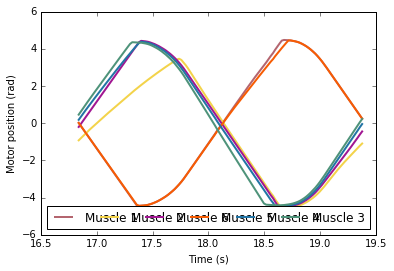

In [120]:
plt.show()

In [166]:
def allRMS(behv1, behv2):
	# calculate all RMS
	results = []
	low = 1e9
	index = 0
	for i in range(behv1[0].shape[0]):
		RMS_ = 0
		for j in range(behv1[0].shape[1]):
			base = np.roll(np.transpose(behv1[0])[j],i)
			data = np.transpose(behv2[0])[j]
			while(len(base) != len(data)):
				if len(base) > len(data):
					base = base[:-1]
				else:
					data = data[:-1]
			RMS_ += RMS(base,data)
		if RMS_ < low:
			low = RMS_
			index = i
		results.append(RMS_)
	return results, low, index

In [167]:
behv1 = fb_base
behv2 = fs_base

In [168]:
results, low, index = allRMS(behv1,behv2)

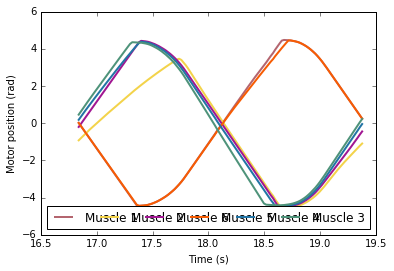

In [59]:
fig1 = plt.figure(1)
plot(fig1, behv1[2],np.transpose(behv1[0]))
plt.show()

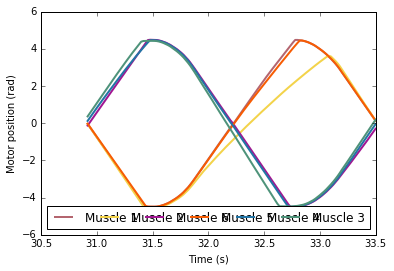

In [74]:
fig2 = plt.figure(2)
plot(fig2, behv2[2],np.roll(np.transpose(behv2[0]),index,axis=1))
plt.show()

In [101]:
def intersections(behv1, behv2):
    # calculate all RMS
    results = []
    for j in range(behv1.shape[1]):
        sect = []
        diff = behv1[0][j] - behv2[0][j]
        for i in range(1,behv1.shape[0]):
            prev_diff = diff
            diff = behv1[i][j] - behv2[i][j]
            if prev_diff/diff < 0:
                print "Motor: ", motor_to_muscle[j], ", Diff: ", diff, ", Index: ", i
                sect.append(i)
        results.append(sect)
    return results

In [93]:
# need to cut one of the behaviors as sample number does not match
np.roll(behv2[0],index,axis=0)[:-2].shape

(128, 14)

In [102]:
intsects = intersections(behv1[0],np.roll(behv2[0],index,axis=0)[:-2])

Motor:  1 , Diff:  -0.00616462943396 , Index:  93
Motor:  2 , Diff:  0.286240341698 , Index:  4
Motor:  2 , Diff:  -0.296435690377 , Index:  69
Motor:  6 , Diff:  0.0164785286792 , Index:  91
Motor:  5 , Diff:  -0.018908815283 , Index:  96
Motor:  4 , Diff:  -0.00580897773585 , Index:  12
Motor:  4 , Diff:  0.0366321249057 , Index:  90
Motor:  3 , Diff:  -0.0292227145283 , Index:  24
Motor:  3 , Diff:  0.0648471596226 , Index:  86


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


In [96]:
intsects

[[], [93], [], [4, 69], [91], [96], [], [], [], [], [12, 90], [], [24, 86], []]

In [98]:
motor_to_muscle = [0, 1, 0, 2, 6, 5, 0, 0, 0, 0, 4, 0, 3, 0]

In [108]:
# Problem: There are intersection for the motors that are very similar or even nearly parallel for the most part.
#     Consequently, the intersection can occur far from the coincident state.
# Proposed solution: Use an RMS threshold for each muscle to avoid calculating the intersection for muscles
#     with very small differences
def muscleRMS(behv1, behv2):
    # calculate all muscle RMS'
    results = []
    #iterate over all muscles
    for j in range(behv1.shape[1]):
        results.append(RMS(behv1[:,j],behv2[:,j]))
    return results

In [117]:
muscle_rms = muscleRMS(behv1[0],np.roll(behv2[0],index,axis=0)[:-2])

In [118]:
muscle_rms

[0.0,
 0.15166880466532523,
 0.0,
 5.0861310155578865,
 0.14393410426278963,
 0.15243982365946279,
 0.0,
 0.0,
 0.0,
 0.0,
 0.22577641003997609,
 0.0,
 0.27226656090997792,
 0.0]

In [202]:
# use arbitrary cutoff RMS of 0.5 to not calculate other than muscle 2 intersection
def intersections(behv1, behv2, muscle_rms):
    # calculate all RMS
    results = []
    for j in range(behv1.shape[1]):
        sect = []
        if muscle_rms[j] > 0.5:        
            diff = behv1[0][j] - behv2[0][j]
            for i in range(1,behv1.shape[0]):
                prev_diff = diff
                diff = behv1[i][j] - behv2[i][j]
                if prev_diff/diff < 0:
                    print "Motor: ", motor_to_muscle[j], ", Index: ", i-1
                    sect.append((i-1,behv1[i-1,j]))
            results.append(sect)
    return results

In [203]:
intsects = intersections(behv1[0],np.roll(behv2[0],index,axis=0)[:-2],muscle_rms)

Motor:  2 , Index:  3
Motor:  2 , Index:  68


In [204]:
intsects

[[(3, -0.56827213830188672), (68, -0.54551042962264151)]]

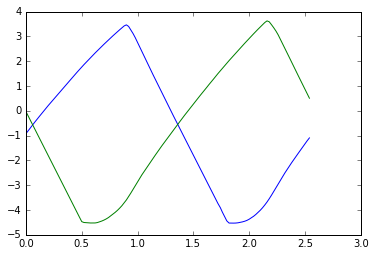

In [205]:
fig = plt.figure(1)
plt.plot(behv1[2]-behv1[2][0],np.transpose(behv1[0])[3])
plt.plot(behv2[2][:-2]-behv2[2][0],np.roll(np.transpose(behv2[0])[3],index)[:-2])
plt.show()

In [206]:
print np.transpose(behv1[0])[3][3],np.roll(np.transpose(behv2[0])[3],index)[:-2][3]

-0.568272138302 -0.561218379623


In [211]:
behv2[0][:-1].shape

(129, 14)